In [1]:
from common import Fonts, Images, NWSL, Colors, add_twitter_handle, add_source
from math import radians, cos, sin, asin, sqrt
from shapely.geometry import Point
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas
import itertools
import math

In [2]:
states = geopandas.read_file('data/usa-states-census-2014.shp')

In [3]:
bounds = states["geometry"].bounds
x_bounds = [min(bounds["minx"]) - 1, max(bounds["maxx"]) + 1]
y_bounds = [min(bounds["miny"]) - 1, max(bounds["maxy"]) + 1]

In [4]:
df = pd.DataFrame(
    [
        ["LA", 34.013, -118.285],
        ["SF", 37.351389, -121.925],
        ["CHI", 41.764722, -87.806111],
        ["HOU", 29.7522, -95.3524],
        ["KCC", 39.120333, -94.56625],
        ["NJNY", 40.736667, -74.150278],
        ["NC", 35.786164, -78.755106],
        ["ORL", 28.5411, -81.3893],
        ["POR", 45.521389, -122.691667],
        ["LOU", 38.259444, -85.731944],
        ["SD", 32.784444, -117.122833],
        ["RGN", 47.5952, -122.3316],
        ["UTA", 40.5829, -111.8934],
        ["WAS", 38.868411, -77.012869],
    ],
    columns=["team", "lat", "long"],
)

In [5]:
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

TEAMS = { team:hex_to_rgb(NWSL.color(team)) for team in df["team"]}
TEAMS

{'LA': (248, 213, 206),
 'SF': (10, 32, 50),
 'CHI': (60, 181, 228),
 'HOU': (255, 106, 1),
 'KCC': (98, 202, 201),
 'NJNY': (169, 241, 245),
 'NC': (215, 195, 139),
 'ORL': (96, 38, 158),
 'POR': (151, 38, 44),
 'LOU': (197, 180, 225),
 'SD': (252, 24, 150),
 'RGN': (0, 47, 135),
 'UTA': (253, 183, 26),
 'WAS': (0, 0, 0)}

In [24]:
def calc_distance(lat1, lat2, lon1, lon2):

    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2

    c = 2 * asin(sqrt(a))

    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371

    # calculate the result
    return c * r


teams = df.copy()


def calc_nearest(row):
    teams["dist"] = teams.apply(
        lambda t: calc_distance(row["lat"], t["lat"], row["long"], t["long"]),
        axis=1,
    )
    idx = teams["dist"].idxmin()
    return (teams.iloc[idx]["team"], teams.iloc[idx]["dist"])


x_mult = (x_bounds[1] - x_bounds[0]) / 1650
y_mult = (y_bounds[1] - y_bounds[0]) / 951


def calc_rgba(row):
    long = x_bounds[0] + row["x"] * x_mult + 0.02
    lat = y_bounds[0] + row["y"] * y_mult + 0.03

    if (states["geometry"].contains(Point(long, lat)).sum()) > 0:
        team, dist = calc_nearest({"lat": lat, "long": long})
        return list(TEAMS[team]) + [(dist % 90) * 255 / 90]
    else:
        return None


grid = pd.DataFrame(
    itertools.product(range(0, 1650), range(0, 951)), columns=["x", "y"]
)
grid["rgba"] = grid.apply(calc_rgba, axis=1)
grid = grid.dropna()

grid_im = np.zeros((951, 1650, 4))
for i, row in grid.iterrows():
    grid_im[row["y"]][row["x"]] = row["rgba"]

grid_im = grid_im.astype("uint8")

/home/agale/.local/lib/python3.8/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<Figure size 2000x2000 with 0 Axes>

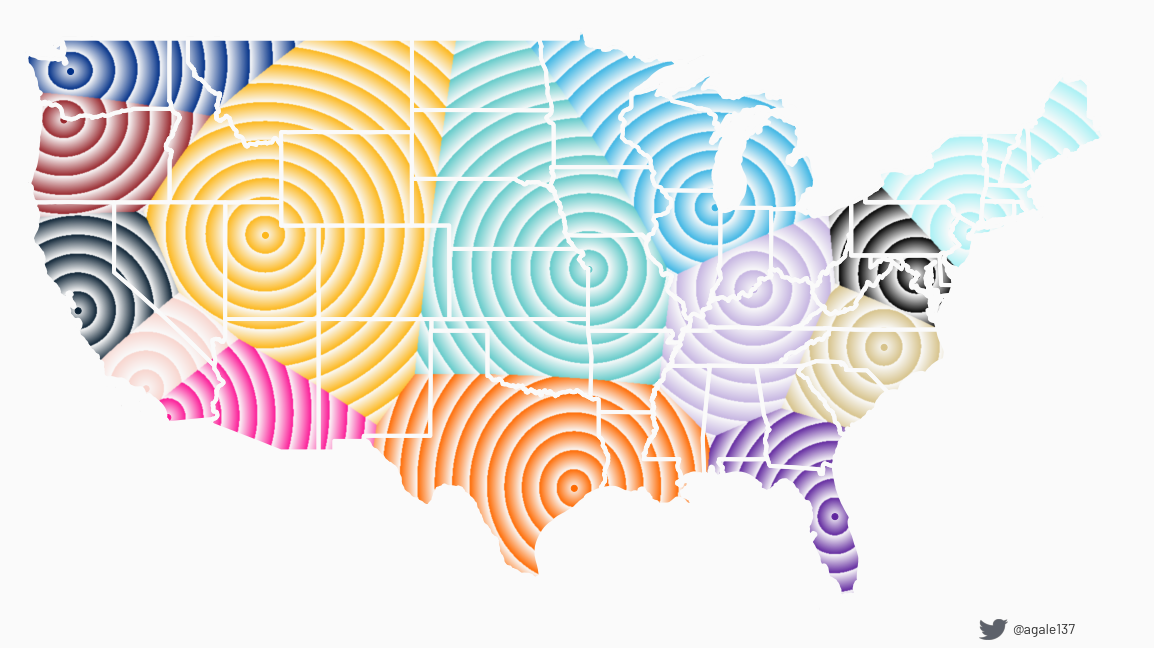

In [25]:
# Setup
plt.rcParams["figure.figsize"] = (20, 20)
plt.figure(dpi=100)
fig, ax = plt.subplots()
fig.patch.set_facecolor(Colors.WHITE)
ax.set_facecolor(Colors.WHITE)

# Plot concentric circles
ax.imshow(grid_im, extent=x_bounds + y_bounds, origin="lower", interpolation="gaussian")

# State outlines
states.boundary.plot(ax=ax, color=Colors.WHITE, linewidth=4)

# Stadium locations
ax.scatter(df["long"], df["lat"], color=df["team"].apply(NWSL.color))

# Hide axis
ax.axis("off")

# Save image
add_twitter_handle(fig, x=0.8, y=0.28, fs=14, w=0.017)
plt.savefig("nearest_white_border_2.png", bbox_inches="tight", pad_inches=0.5, dpi=fig.dpi)

# Albers Projection

In [50]:
# Convert city locations to projection coordinates
df["new_lat"] = 0
df["new_long"] = 0
for i, row in df.iterrows():
    point = Point((row["long"], row["lat"]))
    gdf = geopandas.GeoSeries([point], crs={"init": "epsg:4326"})
    new_point = gdf.to_crs("ESRI:102003")
    df.loc[i, "new_long"] = new_point[0].x
    df.loc[i, "new_lat"] = new_point[0].y

df

/home/agale/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,team,lat,long,new_lat,new_long
0,LA,34.013000,-118.285000,-1.519072e+05,-2.024384e+06
1,SF,37.351389,-121.925000,2.917110e+05,-2.246711e+06
2,CHI,41.764722,-87.806111,5.069436e+05,6.755123e+05
3,HOU,29.752200,-95.352400,-8.646893e+05,6.260433e+04
4,KCC,39.120333,-94.566250,1.825373e+05,1.228103e+05
5,NJNY,40.736667,-74.150278,5.721647e+05,1.813927e+06
6,NC,35.786164,-78.755106,-5.219851e+04,1.536527e+06
7,ORL,28.541100,-81.389300,-8.890852e+05,1.427429e+06
8,POR,45.521389,-122.691667,1.187871e+06,-2.058190e+06
9,LOU,38.259444,-85.731944,1.331516e+05,8.882564e+05


In [57]:
albers_states = states["geometry"].to_crs("ESRI:102003")
albers_bounds = albers_states.bounds
albers_x_bounds = [min(albers_bounds["minx"]) - 1, max(albers_bounds["maxx"]) + 1]
albers_y_bounds = [min(albers_bounds["miny"]) - 1, max(albers_bounds["maxy"]) + 1]

In [ ]:
def calc_distance(lat1, lat2, lon1, lon2):
    return math.sqrt((lat2 - lat1) ** 2 + (lon2 - lon1) ** 2)


teams = df.copy()


def calc_nearest(row):
    teams["dist"] = teams.apply(
        lambda t: calc_distance(row["lat"], t["new_lat"], row["long"], t["new_long"]),
        axis=1,
    )
    idx = teams["dist"].idxmin()
    return (teams.iloc[idx]["team"], teams.iloc[idx]["dist"])


x_mult = (albers_x_bounds[1] - albers_x_bounds[0]) / 1650
y_mult = (albers_y_bounds[1] - albers_y_bounds[0]) / 951


def calc_rgba(row):
    long = albers_x_bounds[0] + row["x"] * x_mult + 0.02
    lat = albers_y_bounds[0] + row["y"] * y_mult + 0.03

    if (albers_states.contains(Point(long, lat)).sum()) > 0:
        team, dist = calc_nearest({"lat": lat, "long": long})
        return list(TEAMS[team]) + [(dist % 90000) * 255 / 90000]
    else:
        return None


grid = pd.DataFrame(
    itertools.product(range(0, 1650), range(0, 951)), columns=["x", "y"]
)
grid["rgba"] = grid.apply(calc_rgba, axis=1)
grid = grid.dropna()

grid_im = np.zeros((951, 1650, 4))
for i, row in grid.iterrows():
    grid_im[row["y"]][row["x"]] = row["rgba"]

grid_im = grid_im.astype("uint8")

In [ ]:
# Setup
plt.rcParams["figure.figsize"] = (20, 20)
plt.figure(dpi=100)
fig, ax = plt.subplots()
fig.patch.set_facecolor(Colors.WHITE)
ax.set_facecolor(Colors.WHITE)

# Plot concentric circles
ax.imshow(grid_im, extent=albers_x_bounds + albers_y_bounds, origin="lower", interpolation="gaussian")

# State outlines
states.boundary.to_crs("ESRI:102003").plot(ax=ax, color=Colors.WHITE, linewidth=2)

# Stadium locations
ax.scatter(df["new_long"], df["new_lat"], color=df["team"].apply(NWSL.color))

# Hide axis
ax.axis("off")

# Save image
add_twitter_handle(fig, x=0.8, y=0.28, fs=14, w=0.017)
plt.savefig("nearest_albers.png", bbox_inches="tight", pad_inches=0.5, dpi=fig.dpi)